# 分析自如租房数据
1、数据采集于自如网站  
2、使用多元线性回归模型分析房子的各个特征与租房价格的关系

In [198]:
%matplotlib inline
from pymongo import MongoClient
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei']
import re

# 一：数据预处理

### 1 - 从数据库中加载数据写入文件

In [2]:

def get_min_dis(room_subway_list):
    """获取离地铁最近的距离"""
    minv = 3000 
    for item in room_subway_list:
        ret = re.findall('\d+', item)
        if ret:
            if int(ret[-1]) < minv:
                minv = int(ret[-1])

    return minv
fields = ['_id', 'room_iswith', 'room_size','room_area','room_face',  
              'room_huxing','lat', 'lng', 'room_subway', 'room_subway_list','room_floor', 'room_price']
chinese_fields = ['id', '出租类型','房间大小(m2)','区域','朝向','户型','经度',
                  '纬度', '临近地铁', '离地铁最近距离(米)', '所在楼层', '出租价格(元)']

In [6]:
# 房源总数
!wc -l ziru_house.txt

   92789 ziru_house.txt


### 2 - 转成DataFrame

In [4]:
raw_data = pd.read_csv('ziru_house.txt')
for field in raw_data.columns:
    if field not in fields:
        del raw_data[field]


In [5]:
raw_data.count()

_id                 92788
room_iswith         91834
room_size           91789
room_area           92788
room_face           92784
room_huxing         92788
lat                 92788
lng                 92788
room_subway         81220
room_subway_list    92788
room_floor          92788
room_price          92788
dtype: int64

### 3 - 异常值清洗

In [6]:
# 将所有缺失值填充成0
raw_data = raw_data.fillna(0)

In [7]:
def get_inverse_list(col_name, legal_list):
    ex_list = list(raw_data[col_name].value_counts().index)
    newlist = filter(lambda x : x not in legal_list, ex_list)
    return list(newlist)


In [8]:
# 删除room_size>200 和room_size < 5的异常数据
raw_data.drop(raw_data[raw_data['room_size'] > 200].index,inplace=True)
raw_data.drop(raw_data[raw_data['room_size'] < 5].index,inplace=True)
# 删除价格小于800的异常值
raw_data.drop(raw_data[raw_data['room_price'] < 800].index,inplace=True)

# 删除room_iswith不为整租或合租
ROOM_ISWITH_LIST = [u'整', u'合']
ex_list = get_inverse_list('room_iswith', ROOM_ISWITH_LIST)
raw_data.drop(raw_data[raw_data['room_iswith'].isin(ex_list)].index,inplace=True)

# # 删除行政区不对的
ROOM_AERA_LIST = [u'朝阳', u'海淀', u'丰台', u'昌平', u'通州', u'大兴', u'西城', u'顺义', u'东城', u'石景山', u'房山', u'亦庄开发区', u'门头沟']
ex_list = get_inverse_list('room_area', ROOM_AERA_LIST)
raw_data.drop(raw_data[raw_data['room_area'].isin(ex_list)].index,inplace=True)

# # 删除朝向不对的
ROOM_FACE_LIST = [u'南',u'北',u'东',u'西',u'南北',u'东南',u'西南',u'西北',u'东北',u'东西']
ex_list = get_inverse_list('room_face', ROOM_FACE_LIST)
raw_data.drop(raw_data[raw_data['room_face'].isin(ex_list)].index,inplace=True)

# # 删除户型不对的
ROOM_HUXING_LIST = [u'3室1厅',u'4室1厅',u'2室1厅',u'1室1厅',u'5室1厅',
                    u'6室1厅',u'4室2厅',u'2室2厅',u'3室2厅',u'5室2厅',
                    u'7室1厅',u'6室2厅',u'2室0厅',u'1室0厅',u'1室2厅',
                    u'7室2厅',u'4室0厅',u'5室3厅',u'8室1厅',u'9室3厅',u'3室0厅']
ex_list = get_inverse_list('room_huxing', ROOM_HUXING_LIST)
raw_data.drop(raw_data[raw_data['room_huxing'].isin(ex_list)].index,inplace=True)

In [9]:
raw_data.count()

_id                 76319
room_iswith         76319
room_size           76319
room_area           76319
room_face           76319
room_huxing         76319
lat                 76319
lng                 76319
room_subway         76319
room_subway_list    76319
room_floor          76319
room_price          76319
dtype: int64

In [10]:
raw_data.head()

,_id,room_iswith,room_size,room_area,room_face,room_huxing,lat,lng,room_subway,room_subway_list,room_floor,room_price
0,BJZRGY081769284_01,合,10.00,海淀,南,3室1厅,40.024767,116.289076,16号线,347,1/11层,2660
1,BJZRGZ111784464,整,54.97,朝阳,南北,2室1厅,39.965058,116.469961,10号线,485,3/6层,7260
3,BJZRHD68044884,整,57.00,海淀,东西,2室1厅,40.037549,116.336905,13号线,912,6/6层,5660
4,BJZRCY16000582,整,46.12,朝阳,东,2室1厅,39.933755,116.621507,6号线,332,11/17层,5780
5,BJZRXC95874513,整,43.10,西城,南,1室1厅,39.940291,116.353434,6号线,264,6/6层,5490


In [139]:
house_data = raw_data.copy()

## 二： 数据分析

In [11]:
hdata = raw_data.copy()
hdata.columns = fields

### 房间数量分布

Text(0,0.5,'行政区域')

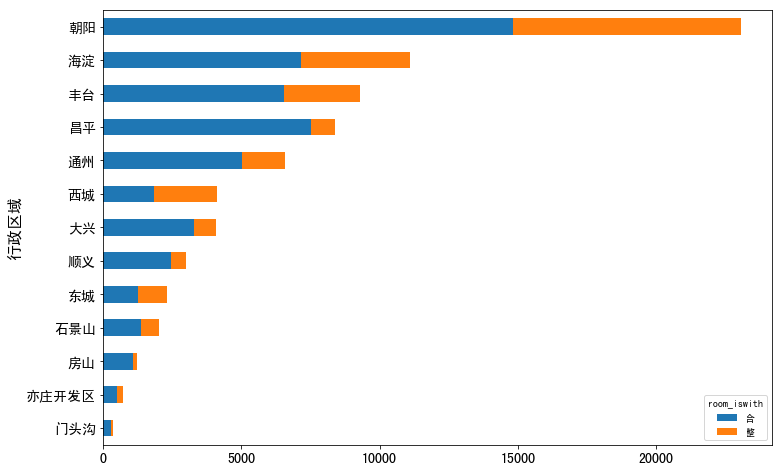

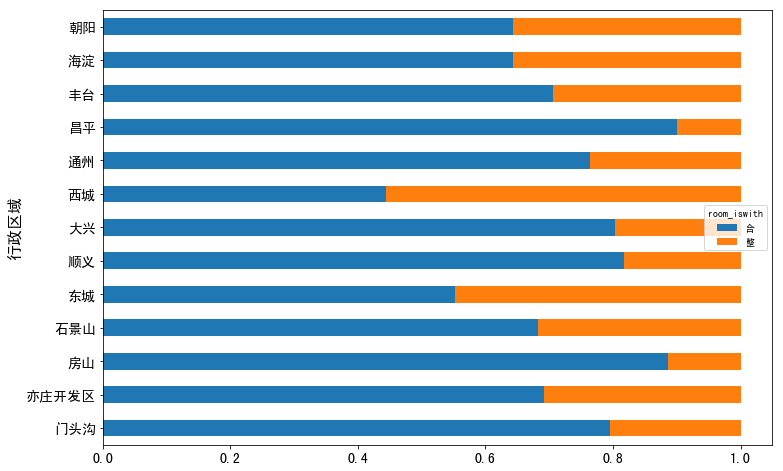

In [43]:

area_counts = hdata.groupby(['room_area', 'room_iswith']).size().unstack()
indexer = area_counts.sum(1).argsort()
area_counts = area_counts.take(indexer)


area_counts.plot(kind='barh', stacked=True,figsize=[12,8],rot=0, fontsize=14)
plt.ylabel('行政区域', fontsize=16)

noremed_counts = area_counts.div(area_counts.sum(1), axis=0)
noremed_counts.plot(kind='barh', stacked=True, figsize=[12,8], fontsize=14)
plt.ylabel('行政区域', fontsize=16)

# plt.show()

[ 1  2  3  4  5  6  7  8  9 10 11 12 13] [23047, 11114, 9280, 8375, 6598, 4135, 4089, 3004, 2328, 2021, 1221, 737, 370]


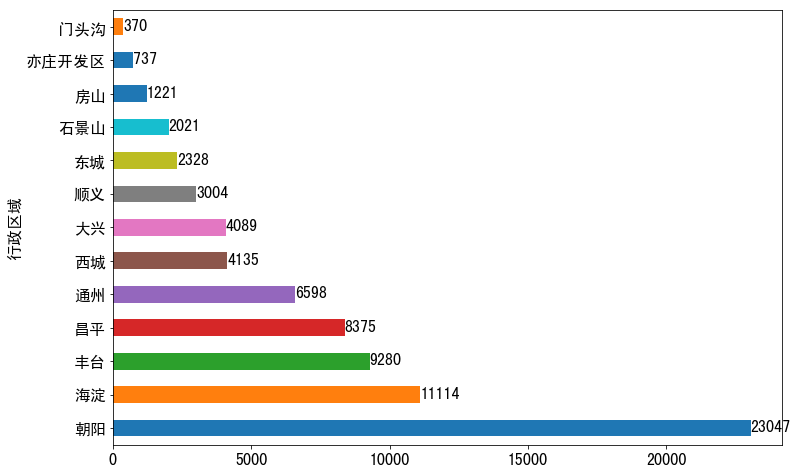

In [35]:
plt.figure(num=1, figsize=[12,8])
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.ylabel('行政区域', fontsize=16)
area_counts = hdata['room_area'].value_counts()
area_counts.plot(kind='barh',rot=0, position=0.5)

xlen = np.arange(len(area_counts))+1
yarr = list(area_counts)
print(xlen, yarr)
for a,b in zip(xlen,yarr):
    plt.text(b-1, a-1.1, '%.0f' % b ,fontsize=16)

### 价格分布

Text(0.5,0,'行政区域')

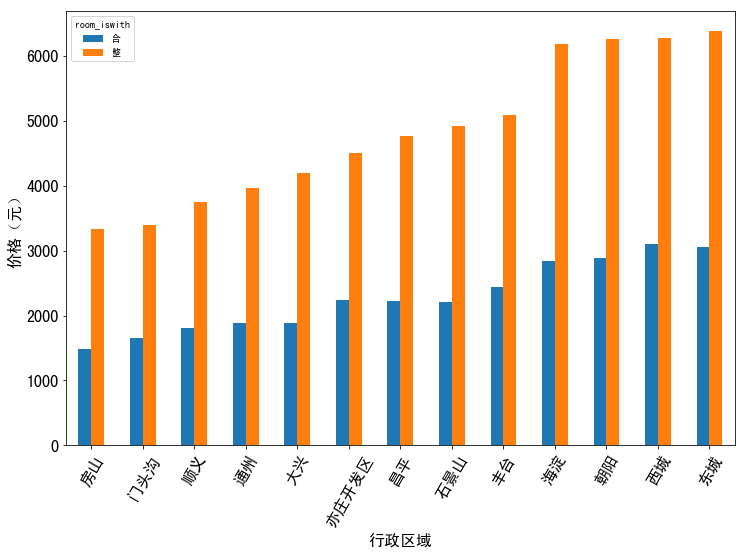

In [81]:

price_counts = hdata.groupby(['room_area', 'room_iswith'])['room_price'].mean().unstack()

indexer = price_counts.mean(1).argsort(axis=1)

price_counts = price_counts.take(indexer)
price_counts.plot(kind='bar', stacked=False,figsize=[12,8],rot=60, fontsize=14)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.ylabel('价格（元）', fontsize=16)
plt.xlabel('行政区域', fontsize=16)

Text(0.5,0,'行政区域')

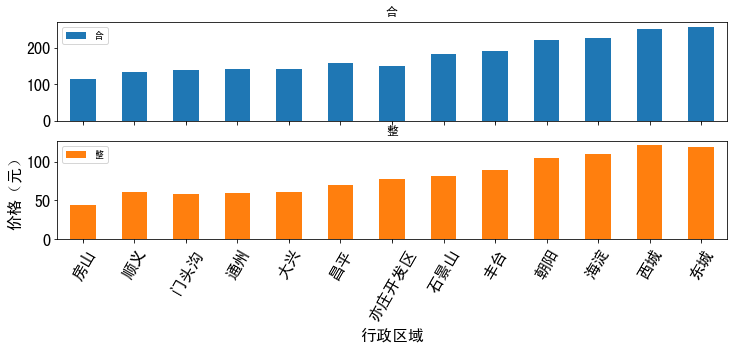

In [356]:
## 平均价
avg_per_price = hdata.groupby(['room_area','room_iswith'])['room_price', 'room_size'].sum().unstack()
avg_per_price_stat = avg_per_price['room_price'] / avg_per_price['room_size']

indexer = avg_per_price_stat.mean(1).argsort(axis=1)
avg_per_price_stat = avg_per_price_stat.take(indexer)

avg_per_price_stat.plot(kind='bar',figsize=[12,4],rot=60, fontsize=16, subplots=True)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.ylabel('价格（元）', fontsize=16)
plt.xlabel('行政区域', fontsize=16)

### 各个地区合租和整租的房子大小和价格的均值，标准差、最大最小值，四分位数

In [414]:
hdata1 = hdata[hdata['room_iswith'] == '合'][['room_area','room_price']]\
            .groupby(['room_area'])['room_price'].describe()
del hdata1['count']
hdata1 = hdata1.T
hdata1.round()

room_area,东城,丰台,亦庄开发区,大兴,房山,昌平,朝阳,海淀,石景山,西城,通州,门头沟,顺义
mean,3055.0,2442.0,2235.0,1882.0,1481.0,2231.0,2891.0,2838.0,2204.0,3095.0,1878.0,1655.0,1807.0
std,531.0,411.0,477.0,362.0,193.0,470.0,637.0,637.0,407.0,535.0,332.0,200.0,373.0
min,1890.0,1390.0,1260.0,1130.0,930.0,990.0,1260.0,1360.0,1330.0,1630.0,1090.0,1290.0,890.0
25%,2690.0,2190.0,1890.0,1630.0,1360.0,1890.0,2460.0,2390.0,1890.0,2690.0,1630.0,1490.0,1530.0
50%,2990.0,2390.0,2190.0,1790.0,1460.0,2190.0,2790.0,2790.0,2160.0,3090.0,1830.0,1630.0,1760.0
75%,3390.0,2690.0,2490.0,2090.0,1630.0,2560.0,3290.0,3260.0,2390.0,3490.0,2090.0,1790.0,2030.0
max,7390.0,4460.0,3990.0,3660.0,2190.0,5290.0,6960.0,8760.0,4190.0,5990.0,3690.0,2690.0,3760.0


In [415]:
hdata2 = hdata[hdata['room_iswith'] == '整'][['room_area','room_price']]\
            .groupby(['room_area'])['room_price'].describe()
del hdata2['count']
hdata2 = hdata2.T
hdata2.round()

room_area,东城,丰台,亦庄开发区,大兴,房山,昌平,朝阳,海淀,石景山,西城,通州,门头沟,顺义
mean,6381.0,5094.0,4506.0,4197.0,3328.0,4774.0,6254.0,6187.0,4915.0,6281.0,3969.0,3399.0,3750.0
std,1254.0,844.0,918.0,844.0,607.0,1129.0,1438.0,1331.0,1012.0,1551.0,807.0,583.0,750.0
min,3790.0,2890.0,2630.0,2790.0,2430.0,2090.0,3030.0,3090.0,2930.0,2860.0,2230.0,2690.0,2430.0
25%,5500.0,4500.0,3860.0,3598.0,2690.0,3992.0,5350.0,5320.0,4290.0,5360.0,3390.0,2990.0,3290.0
50%,6290.0,5030.0,4290.0,4010.0,3330.0,4810.0,6060.0,5990.0,4720.0,6090.0,3790.0,3275.0,3590.0
75%,7035.0,5530.0,4945.0,4490.0,3840.0,5490.0,6830.0,6860.0,5190.0,6990.0,4430.0,3690.0,3930.0
max,16520.0,10260.0,9000.0,8490.0,4590.0,9000.0,14570.0,15570.0,9860.0,16070.0,7230.0,5390.0,7660.0


In [358]:
def trans_to(room_iswith='合'):
    sort_map = ['西城','东城','朝阳','海淀','丰台','亦庄开发区','昌平','石景山','大兴','通州','顺义','门头沟','房山']
    records = {}
    for item in hdata[hdata['room_iswith'] == room_iswith][['room_area','room_price']].to_dict(orient='records'):
        _key = item['room_area']
        if _key not in records:
            records.setdefault(_key, [])
        records[_key].append(item['room_price'])

    newrecords = []
    for area in sort_map:
        newrecords.append(records[area])
    return sort_map,newrecords

keys, records = trans_to()
keys2,records_2 = trans_to('整')

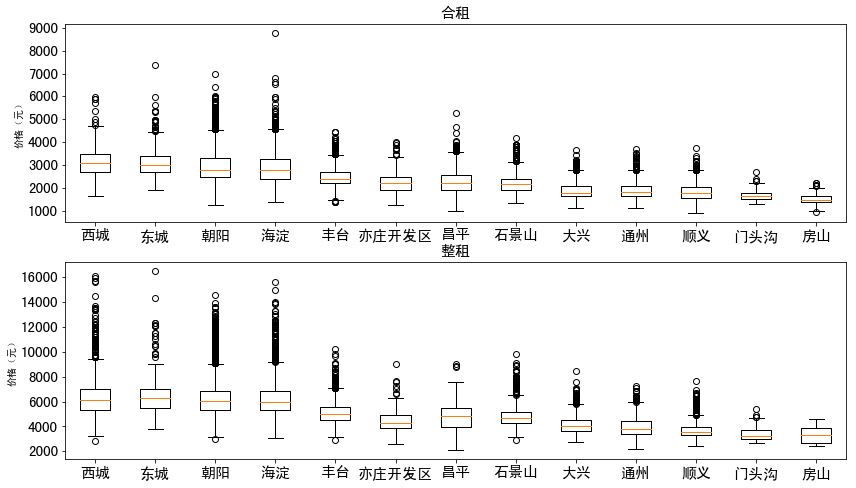

In [359]:
#绘制箱线图
plt.figure(num=1, figsize=[14,8])
plt.subplot(211)
plt.boxplot(records, labels=keys, showfliers=True)
plt.title('合租',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel('价格（元）')

plt.subplot(212)
plt.boxplot(records_2, labels=keys2, showfliers=True)
plt.title('整租',fontsize=15)
plt.ylabel('价格（元）')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.show()

In [357]:
hdata2 = hdata[hdata['room_iswith'] == '合'][['room_area','room_size','room_price']]\
    .groupby(['room_area'])[['room_size','room_price']].sum().reset_index()

In [364]:
hdata2['平均价/每平米'] = hdata2['room_price']/hdata2['room_size']
hdata2

,room_area,room_size,room_price,平均价/每平米
0,东城,15228.98,3922530,257.570106
1,丰台,84319.49,16003560,189.796689
2,亦庄开发区,7566.46,1139820,150.641119
3,大兴,43752.55,6175950,141.156344
4,房山,14104.32,1602330,113.605619
5,昌平,107092.49,16825940,157.115966
6,朝阳,192938.85,42864860,222.168112
7,海淀,89943.90,20310602,225.814113
8,石景山,16496.21,3036960,184.100469
9,西城,22536.41,5679960,252.034818


## 房屋综合竞争力指数


5、	各个行政区域租房综合  
a)	地铁距离  
b)	合租或整租平均价  
c)	房间平均大小  
d)	距离市中心距离  
e)	楼层平均高度  
f)	距离热门区域最短平均距离（国贸、望京、中关村、西二旗）  


In [145]:
tc_data = house_data[['room_iswith', 'room_size', 'room_area', 'room_subway_list', 'room_floor', 'room_price']].head()

In [146]:
house_data.head()

,_id,room_iswith,room_size,room_area,room_face,room_huxing,lat,lng,room_subway,room_subway_list,room_floor,room_price
0,BJZRGY081769284_01,合,10.00,海淀,南,3室1厅,40.024767,116.289076,16号线,347,1/11层,2660
1,BJZRGZ111784464,整,54.97,朝阳,南北,2室1厅,39.965058,116.469961,10号线,485,3/6层,7260
3,BJZRHD68044884,整,57.00,海淀,东西,2室1厅,40.037549,116.336905,13号线,912,6/6层,5660
4,BJZRCY16000582,整,46.12,朝阳,东,2室1厅,39.933755,116.621507,6号线,332,11/17层,5780
5,BJZRXC95874513,整,43.10,西城,南,1室1厅,39.940291,116.353434,6号线,264,6/6层,5490


In [148]:
# 天安门的经纬度
CENTER_LAT,CENTER_LNG = 39.9152108931,116.4039006839

HOT_AERA = [
    [39.9899909577,116.3231022233], #中关村
    [39.9084853209,116.4601421356], # 国贸
    [40.0591382065,116.3127016558], #西二旗地铁
    [40.0040337129,116.4759271178], # 望京
]

EARTH_REDIUS = 6378.137
PI = 3.1314159
import math
def get_distance(lat1, lng1, lat2=CENTER_LAT, lng2=CENTER_LNG):
    radLat1 = lat1 * PI / 180.0
    radLat2 = lat2 * PI / 180.0
    a = radLat1 - radLat2
    b = lng1 * PI / 180.0 - lng2 * PI / 180.0
    s = 2 * math.asin(math.sqrt(math.pow(math.sin(a/2), 2) + math.cos(radLat1) * math.cos(radLat2) * math.pow(math.sin(b/2), 2)))
    s = s * EARTH_REDIUS
    return s


def get_min_hot_dis(lat1, lng1):
    mindis = 1000000
    for area in HOT_AERA:
        dis = get_distance(lat1, lng1, area[0], area[1])
        if dis < mindis:
            mindis = dis
    
    return mindis

In [149]:
house_data['center_dis'] = house_data.apply(lambda x: get_distance(x['lat'], x['lng']), axis=1)

In [173]:
# 到市中心的距离
groupcenter_dis = house_data.groupby(['room_area','room_iswith'])['center_dis'].mean().unstack()

In [151]:
house_data['hot_min_dis'] = house_data.apply(lambda x: get_min_hot_dis(x['lat'], x['lng']), axis=1)

In [174]:
## 距离热门区域的最短平均距离
grouphot_min_dis = house_data.groupby(['room_area','room_iswith'])['hot_min_dis'].mean().unstack()

In [159]:
## 合租和整租的平均价
avg_per_price = house_data.groupby(['room_area','room_iswith'])['room_price', 'room_size'].sum().unstack()
avg_per_price_stat = avg_per_price['room_price'] / avg_per_price['room_size']
avg_per_price_stat

room_iswith,合,整
room_area,,
东城,257.570106,118.404342
丰台,189.796689,89.036708
亦庄开发区,150.641119,77.005250
大兴,141.156344,60.805163
房山,113.605619,44.630918
昌平,157.115966,69.581430
朝阳,222.168112,104.019050
海淀,225.814113,110.378328
石景山,184.100469,81.191637


In [175]:
## 合租和整租的平均大小
grouproom_size = house_data.groupby(['room_area','room_iswith'])['room_size'].mean().unstack()

In [170]:
## 距离地铁的平均距离
grouproom_subway = house_data.groupby(['room_area','room_iswith'])['room_subway_list'].mean().unstack()
grouproom_subway

room_iswith,合,整
room_area,,
东城,490.400312,500.290230
丰台,734.970548,667.994133
亦庄开发区,991.564706,597.466960
大兴,916.764401,851.267327
房山,1009.957486,769.964029
昌平,892.108606,1036.776978
朝阳,637.084918,634.588858
海淀,877.980858,796.157948
石景山,1036.161829,1014.489891


In [164]:
## 楼层平均高度
import re
room_floor_pattern = re.compile(r'\d+/\d+')
def prepare_room_floor(room_floor):
    try:    
        room_floor.replace(u'层', '')
        ret = re.match(room_floor_pattern, room_floor)
        if not ret:
            return 0.5
        a, b = ret.group().split('/')
        if (int(a) <= int(b)):
            return float(a) / int(b)
    except:
        pass

    return 0.5

house_data['room_floor'] = house_data.apply(lambda x: prepare_room_floor(x['room_floor']), axis=1)

In [165]:
house_data.head()

,_id,room_iswith,room_size,room_area,room_face,room_huxing,lat,lng,room_subway,room_subway_list,room_floor,room_price,center_dis,hot_min_dis
0,BJZRGY081769284_01,合,10.00,海淀,南,3室1厅,40.024767,116.289076,16号线,347,0.090909,2660,15.603740,4.311392
1,BJZRGZ111784464,整,54.97,朝阳,南北,2室1厅,39.965058,116.469961,10号线,485,0.500000,7260,7.892758,4.354458
3,BJZRHD68044884,整,57.00,海淀,东西,2室1厅,40.037549,116.336905,13号线,912,1.000000,5660,14.725515,3.159262
4,BJZRCY16000582,整,46.12,朝阳,东,2室1厅,39.933755,116.621507,6号线,332,0.647059,5780,18.665541,14.040470
5,BJZRXC95874513,整,43.10,西城,南,1室1厅,39.940291,116.353434,6号线,264,1.000000,5490,5.123856,6.090188


In [167]:
grouproom_floor = house_data.groupby(['room_area','room_iswith'])['room_floor'].mean().unstack()

In [171]:
grouproom_floor.merge(grouproom_subway)

room_iswith,合,整


In [178]:
tz_counts = pd.concat([grouproom_floor,grouproom_size, grouproom_subway, avg_per_price_stat, groupcenter_dis,grouphot_min_dis], axis=1)

In [341]:
tz_counts

room_iswith,合,整,合,整,合,整,合,整,合,整,合,整
room_area,,,,,,,,,,,,
东城,0.584823,0.572500,11.860576,53.888094,490.400312,500.290230,257.570106,118.404342,4.217569,4.200972,4.293186,4.119544
丰台,0.553679,0.581026,12.867311,57.208680,734.970548,667.994133,189.796689,89.036708,9.133648,8.260261,11.167883,9.985908
亦庄开发区,0.550567,0.571820,14.836196,58.517093,991.564706,597.466960,150.641119,77.005250,16.052301,15.578499,13.291720,12.679497
大兴,0.600638,0.572209,13.335126,69.029097,916.764401,851.267327,141.156344,60.805163,17.550903,18.709127,18.200408,19.704412
房山,0.571312,0.564015,13.035416,74.571655,1009.957486,769.964029,113.605619,44.630918,26.459986,26.398901,29.019331,29.164439
昌平,0.602089,0.560815,14.201365,68.605384,892.108606,1036.776978,157.115966,69.581430,20.566551,21.889185,6.852323,7.082844
朝阳,0.548948,0.560075,13.013547,60.124639,637.084918,634.588858,222.168112,104.019050,10.675519,9.606695,5.230465,4.855596
海淀,0.587054,0.577887,12.567263,56.050298,877.980858,796.157948,225.814113,110.378328,14.041600,11.212497,5.128084,4.640061
石景山,0.561163,0.586995,11.971125,60.534355,1036.161829,1014.489891,184.100469,81.191637,16.874600,16.171950,12.769945,12.554626


In [345]:
columns = ['楼层比', '房间大小', '地铁距离', '每平米价格', '市中心距离', '热门区域距离']

In [346]:
he_index = tz_counts.loc[:,'合']
he_index.columns =columns

In [347]:
he_index = he_index.apply(lambda x:  100 - (x - np.min(x)) / (np.max(x) - np.min(x)) * 100)
he_index['房间大小'] = he_index['房间大小'].apply(lambda x: 100 - x)
he_index.reset_index()

,room_area,楼层比,房间大小,地铁距离,每平米价格,市中心距离,热门区域距离
0,东城,68.537834,0.000000,100.000000,0.000000,100.000000,100.000000
1,丰台,95.850584,33.832778,90.254612,47.076483,80.894747,72.196651
2,亦庄开发区,98.580275,100.000000,80.030106,74.274558,54.006940,63.607210
3,大兴,54.669167,49.554388,83.010673,80.862832,48.182956,43.754995
4,房山,80.386850,39.482181,79.297209,100.000000,13.559780,0.000000
5,昌平,53.396169,78.665569,83.993133,69.777028,36.463308,89.650077
6,朝阳,100.000000,38.747250,94.155060,24.590783,74.902612,96.209361
7,海淀,66.581719,23.749220,84.556081,22.058213,61.821082,96.623424
8,石景山,89.287728,3.715142,78.253045,51.033167,50.811257,65.717426
9,西城,37.522554,14.143138,93.989501,3.844898,97.640752,85.274963


In [348]:
zheng_index = tz_counts.loc[:,'整']
zheng_index.columns =columns

In [349]:
zheng_index = zheng_index.apply(lambda x:  100 - (x - np.min(x)) / (np.max(x) - np.min(x)) * 100)
zheng_index['房间大小'] = zheng_index['房间大小'].apply(lambda x: 100 - x)
zheng_index.reset_index()

,room_area,楼层比,房间大小,地铁距离,每平米价格,市中心距离,热门区域距离
0,东城,74.019296,8.755406,100.000000,3.411918,100.000000,100.000000
1,丰台,61.741171,23.404022,93.291065,41.861583,84.109161,76.576606
2,亦庄开发区,74.998356,29.176025,96.112479,57.613806,55.460557,65.821565
3,大兴,74.438133,75.549255,85.959286,78.823820,43.205134,37.772276
4,房山,86.238809,100.000000,89.211796,100.000000,13.102084,0.000000
5,昌平,90.846240,73.680065,78.538038,67.333466,30.756205,88.168046
6,朝阳,91.912332,36.267645,94.627431,22.245905,78.838295,97.061067
7,海淀,66.260990,18.293873,88.163917,13.920002,72.552081,97.921663
8,石景山,53.145641,38.075085,79.429625,52.132766,53.137385,66.320152
9,西城,58.710060,0.000000,93.940454,0.000000,97.631063,84.646823


### 绘制雷达图

#### 合租雷达图

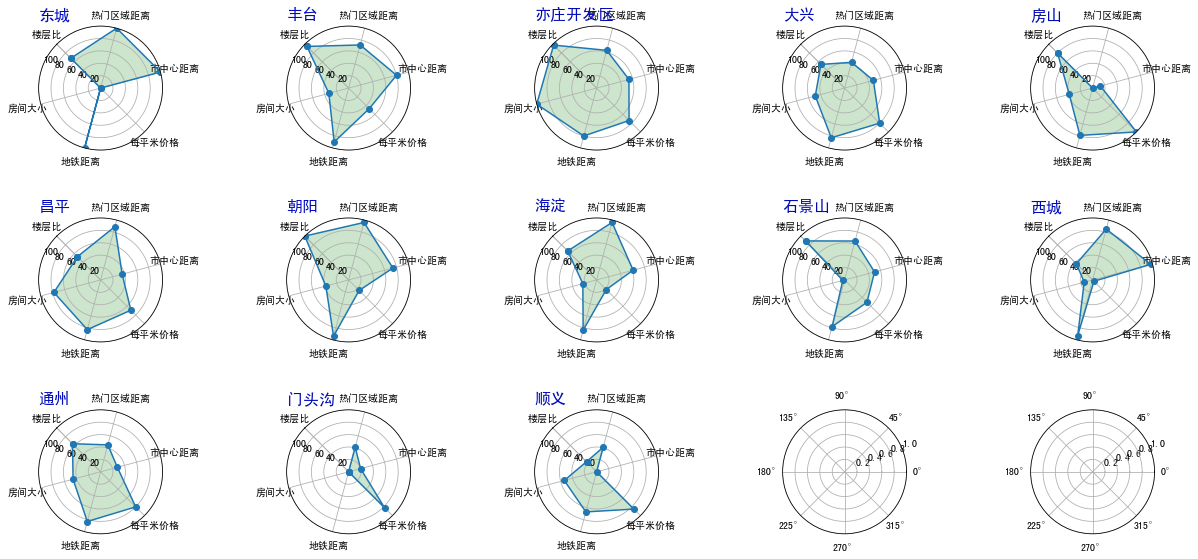

In [354]:
fig1, axs1 = plt.subplots(3, 5,figsize=(20,10), subplot_kw=dict(polar=True))
fig1.subplots_adjust(wspace=1) #设置子图间的间距，为子图宽度的140%
axIdx = 0
for idx in he_index.index:
    p = he_index.loc[idx].to_dict()
    data=np.array([i for i in p.values()]).astype(int)
    label=np.array([j for j in p.keys()]) #提取标签
    angle = np.linspace(0, 2*np.pi, len(data), endpoint=False)
    angles = np.concatenate((angle, [angle[0]]))

    data = np.concatenate((data, [data[0]]))
    ax = axs1.flat[axIdx]
    axIdx += 1
    ax.set_thetagrids(angles*180/np.pi, label) #设置网格标签
    ax.plot(angles,data,"o-")
    ax.set_theta_zero_location('NW') #设置极坐标0°位置
    ax.set_rlim(0,100) #设置显示的极径范围
    ax.fill(angles,data,facecolor='g', alpha=0.2) #填充颜色
    # ax1.set_rlabel_position('255') #设置极径标签位置
    ax.set_title(idx, fontsize=16 ,loc='left',color='#000bbb') #设置标题

plt.show()

#### 整租雷达图

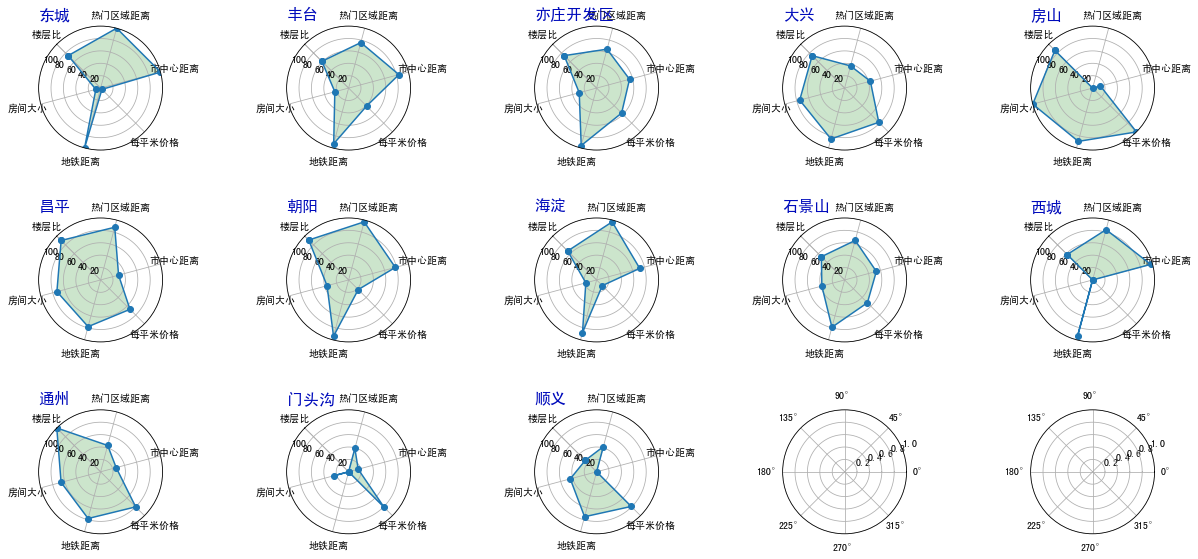

In [361]:
fig2, axs2 = plt.subplots(3, 5,figsize=(20,10), subplot_kw=dict(polar=True))
fig2.subplots_adjust(wspace=1) #设置子图间的间距，为子图宽度的140%
axIdx = 0
for idx in zheng_index.index:
    p = zheng_index.loc[idx].to_dict()
    data=np.array([i for i in p.values()]).astype(int)
    label=np.array([j for j in p.keys()]) #提取标签
    angle = np.linspace(0, 2*np.pi, len(data), endpoint=False)
    angles = np.concatenate((angle, [angle[0]]))

    data = np.concatenate((data, [data[0]]))
    ax = axs2.flat[axIdx]
    axIdx += 1
    ax.set_thetagrids(angles*180/np.pi, label) #设置网格标签
    ax.plot(angles,data,"o-")
    ax.set_theta_zero_location('NW') #设置极坐标0°位置
    ax.set_rlim(0,100) #设置显示的极径范围
    ax.fill(angles,data,facecolor='g', alpha=0.2) #填充颜色
    # ax1.set_rlabel_position('255') #设置极径标签位置
    ax.set_title(idx, fontsize=16 ,loc='left',color='#000bbb') #设置标题

plt.show()